## Digit Recongnition

Model takes encoded handwritting images and tries to predict the digit displayed in the picture.  Data from: https://www.kaggle.com/c/digit-recognizer

### Import Libraries and Data

In [44]:
#loading libraries
import pandas as pd
import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'utils'

In [2]:
#loading training data
df = pd.read_csv("train.csv")
print(df.shape)

(42000, 785)


In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#loading test data
df_test = pd.read_csv("test.csv")
df_test.shape

(28000, 784)

In [5]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Management Question

We would like to create a model that can accurately identify handwritten digits.  There are a number of business applications for being able to digitize handwritten numbers.  This includes bank wanting to have software that can automatically read amounts from a check image. 

### Standardizing the Independent Variables

We are going to do a PCA.  PCA is effected by scale so we standardize the data here and will use the standarized data throughout the entirity of the analysis

In [6]:
#merge datasets together and then scale
df_temp1 = df.drop(columns=['label'])
df_temp1['source'] = 'train'
df_temp2 = df_test
df_temp2['source'] = 'test'
join_list = [df_temp1,df_temp2]
df_comb = pd.concat(join_list)
df_comb.shape
source = df_comb['source'].to_list()
df_comb2 = df_comb.drop(columns=['source'])
del df_temp1, df_temp2, df_comb

In [7]:
#apply scaling to joined test and train data
col_list = df_comb2.columns
scaler = StandardScaler()
model2=scaler.fit(df_comb2)
df_standard=model2.transform(df_comb2)
df_standard = pd.DataFrame(df_standard,columns=col_list)
print(df_standard.shape)
df_standard.describe()

(70000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,7.000000e+04,7.000000e+04,7.000000e+04,7.000000e+04,7.000000e+04,7.000000e+04,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.823623e-15,-1.137216e-15,2.825315e-15,-3.964385e-16,1.831964e-15,1.212366e-15,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.295091e-02,-2.338733e-02,-1.675050e-02,-1.063784e-02,-8.339086e-03,-5.342334e-03,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.295091e-02,-2.338733e-02,-1.675050e-02,-1.063784e-02,-8.339086e-03,-5.342334e-03,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.295091e-02,-2.338733e-02,-1.675050e-02,-1.063784e-02,-8.339086e-03,-5.342334e-03,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.295091e-02,-2.338733e-02,-1.675050e-02,-1.063784e-02,-8.339086e-03,-5.342334e-03,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.236282e+01,5.965323e+01,9.086908e+01,1.619808e+02,1.634635e+02,1.932091e+02,0.0,0.0,0.0,0.0


In [8]:
df_standard['source'] = source
df_standard.shape

(70000, 785)

### Experiement Flaw

We should not be running our models on the full training data.  We apply a cross-validation approach.  I apply a 80/20 holdout approach below

### Training Datasetup

In [9]:
#splitting the dataframe into explanatory and dependent variables
X = df_standard[df_standard['source'] == 'train']
X = X.drop(columns=['source'])
print(X.shape)
y = df['label']
print(y.shape)

(42000, 784)
(42000,)


In [10]:
#the assignment doesnt ask us to use a cross-validation approach, but I am going to anyway
#I don't want to have to submit every model i produce to Kaggle to evaluate.  As a result, I am using a cross-validation approach so i can compare different models on my own
X_train, X_ctest, y_train, y_ctest = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_ctest.shape)
print(y_train.shape)
print(y_ctest.shape)

(33600, 784)
(8400, 784)
(33600,)
(8400,)


In [11]:
#and while we are at it also outputing the scaled test data
df_test = df_standard[df_standard['source'] == 'test']
df_test = df_test.drop(columns=['source'])

### Accuarcy Function

In [12]:
#bulding a function to evaluate model accuracy
def score(predict,actual):
    return sum(predict == actual) / len(actual)

### Random Forest

In [13]:
#training random forest with default hyperparameters
rf = RandomForestClassifier()
rf_start=datetime.datetime.now()
rf.fit(X_train,y_train)
rf_end=datetime.datetime.now()

In [14]:
#time to fit random forest model
print(rf_end-rf_start)

0:00:21.230343


In [15]:
#evaluate accuracy on holdout data
rf_predict = rf.predict(X_ctest)
score(rf_predict,y_ctest)

0.9651190476190477

Random Forest with default assumptions accurately predicted 96% of the observations in the holdout data

In [16]:
#generating a dataframe for kaggle submission
rf_out = rf.predict(df_test)
df_out = pd.DataFrame(data=rf_out,columns=['Label'])
df_out['ImageId'] = df_out.index + 1
df_out = df_out[['ImageId','Label']]
df_out.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3


In [17]:
#checking the shape of the dataframe and creating the csv 
print(df_out.shape)
df_out.to_csv("RandomForest.csv",index=False)

(28000, 2)


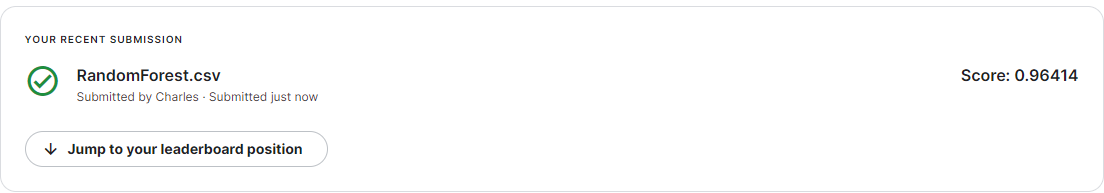

### Principle Component Analysis

In [18]:
#running pca on test + train data
#recording time to run pca
df_pca = df_standard.drop(columns=['source']) #we already have combined test + train that has been standardized: df_standard
pca_start=datetime.datetime.now() #start timer
pca = PCA(n_components=0.95) #retain 95% of varability
pca_reduced = pca.fit_transform(df_pca)
print(pca_reduced.shape)
pca_end=datetime.datetime.now()

(70000, 332)


In [19]:
#PCA time
print(pca_end-pca_start)

0:00:05.201944


### Rebuilding Cross-validation datasets and Test Datasets on PCA database

In [20]:
#add back to PCA data a source identifier
pca = pd.DataFrame(data=pca_reduced)
pca['source'] = source
print(pca.shape)

(70000, 333)


In [21]:
#build training dataset
XC = pca[pca['source'] == 'train']
XC = XC.drop(columns=['source'])
XC.shape

(42000, 332)

In [22]:
#build cross-validation pca data
XP_train, XP_ctest, yp_train, yp_ctest = train_test_split(XC, y, test_size=0.2, random_state=0)
print(XP_train.shape)
print(XP_ctest.shape)
print(yp_train.shape)
print(yp_ctest.shape)

(33600, 332)
(8400, 332)
(33600,)
(8400,)


In [23]:
#building the evaluation data
pca_test = pca[pca['source'] == 'test']
pca_test = pca_test.drop(columns=['source'])
pca_test.shape

(28000, 332)

### Random Forest with PCA

In [24]:
#training random forest with default hyperparameters
rf_pca = RandomForestClassifier()
rf_pca_start=datetime.datetime.now()
rf_pca.fit(XP_train,yp_train)
rf_pca_end=datetime.datetime.now()

In [25]:
#time to fit random forest model
print(rf_pca_end-rf_pca_start)

0:00:57.733329


In [26]:
#evaluate accuracy on holdout data
rf_pca_predict = rf_pca.predict(XP_ctest)
score(rf_pca_predict,yp_ctest)

0.9271428571428572

In [27]:
#generating a dataframe for kaggle submission
rf_pca_out = rf_pca.predict(pca_test)
df_out_2 = pd.DataFrame(data=rf_pca_out,columns=['Label'])
df_out_2['ImageId'] = df_out_2.index + 1
df_out_2 = df_out_2[['ImageId','Label']]
df_out_2.head()

,ImageId,Label
0,1,2
1,2,0
2,3,4
3,4,4
4,5,3


In [28]:
#checking the shape of the dataframe and creating the csv 
print(df_out_2.shape)
df_out_2.to_csv("RandomForest_wPCA.csv",index=False)

(28000, 2)


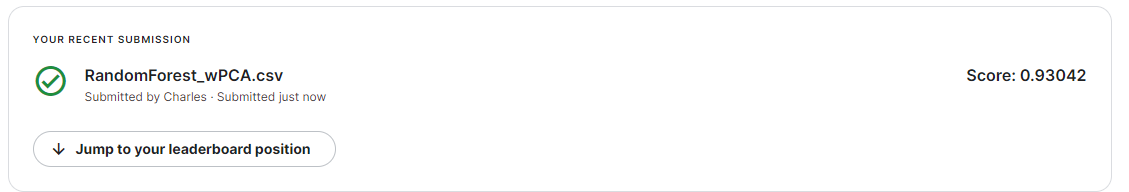

### K-Means Clustering

In [90]:
#applying a k-means with 10 clusters 
n_digits = len(np.unique(y_train))
km = KMeans(n_clusters=n_digits)
km.fit(X_train)

KMeans(n_clusters=10)

In [104]:
#function to create label dictionary
def retrieve_info(cluster_labels,y_train):
    reference_labels = {}

    for i in range(len(np.unique(km.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
        
    return reference_labels

In [120]:
#digit dictionary
reference_labels = retrieve_info(km.labels_,y_train)
dict = {}
for i in reference_labels:
    dict[i] = reference_labels[i]
print(dict)

{0: 2, 1: 4, 2: 7, 3: 3, 4: 1, 5: 0, 6: 2, 7: 5, 8: 7, 9: 6}


In [121]:
#making prediction and labeling
km_predict = km.predict(X_ctest)
km_labeled_predict = np.vectorize(dict.get)(km_predict)

In [122]:
#evaluating accuracy
score(km_labeled_predict,y_ctest)

0.5273809523809524

A pretty bad accruarcy to start.  We also observe from our label dictinary that no predictions are being made for the 8 and 9 digits.  We need to pre-parametrize the model and then re-run

In [123]:
cluster_number = [10,20,50,75,150,300]

for i in cluster_number:
    km = KMeans(n_clusters = i)
    km.fit(X_train)

    reference_labels = retrieve_info(km.labels_,y_train)
    
    dict = {}
    for y in reference_labels:
        dict[y] = reference_labels[y]
    
    km_predict = km.predict(X_ctest)
    km_labeled_predict = np.vectorize(dict.get)(km_predict)
    
    print(score(km_labeled_predict,y_ctest))

0.5282142857142857
0.5919047619047619
0.6798809523809524
0.7323809523809524
0.7645238095238095
0.8210714285714286


I run 6 different k-means models each with an increasing number of nodes.  I fit each model to the training data.  I then make a prediction against our holdout data.  I then measure the accuracy on the holdout data.  We observe that as the number of nodes is increased the accuracy on the holdout data increases.  Given the improvement between 150 and 300 clusters, I run a second set of models testing larger number of clusters

In [124]:
cluster_number = [300,500,1000]

for i in cluster_number:
    km = KMeans(n_clusters = i)
    km.fit(X_train)

    reference_labels = retrieve_info(km.labels_,y_train)
    
    dict = {}
    for y in reference_labels:
        dict[y] = reference_labels[y]
    
    km_predict = km.predict(X_ctest)
    km_labeled_predict = np.vectorize(dict.get)(km_predict)
    
    print(score(km_labeled_predict,y_ctest))

0.8123809523809524
0.848452380952381
0.8764285714285714


Accuracy continues to increase as the number of clusters is increased all the way up to 1000.  We should test models with more than 1000 clusters, but given compute constraints we accept 1000 nodes as our final model

### K-Means Clustering - with 1000 Clusters

In [125]:
km = KMeans(n_clusters = 1000)
km.fit(X_train)

reference_labels = retrieve_info(km.labels_,y_train)
    
dict = {}
for y in reference_labels:
    dict[y] = reference_labels[y]
    
km_predict = km.predict(X_ctest)
km_labeled_predict = np.vectorize(dict.get)(km_predict)

In [129]:
km_predict = km.predict(df_test)
km_labeled_predict = np.vectorize(dict.get)(km_predict)
km_labeled_predict = np.vectorize(dict.get)(km_predict)

In [130]:
#generating a dataframe for kaggle submission
df_out_3 = pd.DataFrame(data=km_labeled_predict,columns=['Label'])
df_out_3['ImageId'] = df_out_3.index + 1
df_out_3 = df_out_3[['ImageId','Label']]
df_out_3.head()

,ImageId,Label
0,1,2
1,2,0
2,3,7
3,4,9
4,5,3


In [131]:
#checking the shape of the dataframe and creating the csv 
print(df_out_3.shape)
df_out_3.to_csv("Kmeans.csv",index=False)

(28000, 2)


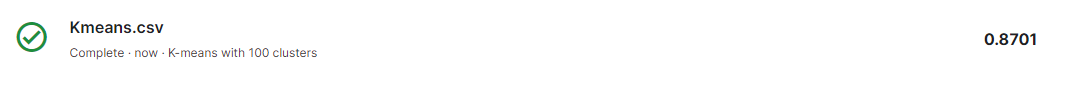